In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
from tensorflow.keras.layers import Embedding, Input, Dropout, Dense, Activation, Reshape, LayerNormalization, Concatenate
from tensorflow.keras.models import Model

In [31]:
class Transformer():
    def __init__(self,
            input_sequence_length=50,
            output_sequence_length=350,
            d_model=512,
            src_vocab_size=10000,
            trg_vocab_size=20000,
            n_blocks_encoder=6,
            n_blocks_decoder=6,
            n_heads=8,
            layer1_units_ff=2048,
            layer2_units_ff=512,
            dropout_rate=0.1
        ):

        self.input_sequence_length=input_sequence_length
        self.output_sequence_length=output_sequence_length
        self.d_model=d_model
        self.src_vocab_size=src_vocab_size
        self.trg_vocab_size=trg_vocab_size
        self.n_blocks_encoder=n_blocks_encoder
        self.n_blocks_decoder=n_blocks_decoder
        self.n_heads=n_heads
        self.layer1_units_ff=layer1_units_ff
        self.layer2_units_ff=layer2_units_ff
        self.dropout_rate=dropout_rate

        self.input_shape_encoder=(input_sequence_length,)
        self.input_shape_decoder=(output_sequence_length,)
        self.intermediate_shape_encoder=(input_sequence_length,d_model)
        self.intermediate_shape_decoder=(output_sequence_length,d_model)
        self.mask_shape_encoder=(1,1,input_sequence_length)
        self.mask_shape_decoder=(1,1,output_sequence_length)

    def EncoderSequenceEmbedding(self,
            input_shape=None,
            d_model=None,
            vocab_size=None,
            dropout_rate=None,
            initializers=None
        ):

        if input_shape is None:
            input_shape=self.input_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if vocab_size is None:
            vocab_size=self.src_vocab_size
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
        if initializers is None:
            initializers=tf.keras.initializers.glorot_uniform(seed=1)

        sequence_length = input_shape[0]
        # Create matrix of shape (seq_len,d_model)
        positionalEncoding = np.zeros((sequence_length,d_model))
        # Create vector of shape (seq_len,1)
        position = np.arange(0,sequence_length).reshape(-1,1)
        # Create denominator of shape (1,d_model)
        div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
        # Apply sin to even positions and cos to odd positions
        positionalEncoding[:,0::2] = np.sin(position*div_term)
        positionalEncoding[:,1::2] = np.cos(position*div_term)
        # Reshape to (1,seq_len,)
        positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

        # Model Architecture
        input = Input(shape=input_shape,name="EmbeddingLayer_Input")

        # Create Input Embedding Layer
        x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding")(input)
        x = x/np.sqrt(d_model)

        # Add Positional Embedding
        x = x + positionalEncoding[:,:x.shape[1],:]
        
        # Dropout
        x = Dropout(rate=dropout_rate,name="Input_Dropout")(x)

        model = Model(inputs=[input],outputs=[x],name="EncoderSequenceEmbedding")

        return model
    
    def DecoderSequenceEmbedding(self,
            input_shape=None,
            d_model=None,
            vocab_size=None,
            dropout_rate=None,
            initializers=None
        ):

        if input_shape is None:
            input_shape=self.input_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if vocab_size is None:
            vocab_size=self.trg_vocab_size
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
        if initializers is None:
            initializers=tf.keras.initializers.glorot_uniform(seed=1)

        sequence_length = input_shape[0]
        # Create matrix of shape (seq_len,d_model)
        positionalEncoding = np.zeros((sequence_length,d_model))
        # Create vector of shape (seq_len,1)
        position = np.arange(0,sequence_length).reshape(-1,1)
        # Create denominator of shape (1,d_model)
        div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
        # Apply sin to even positions and cos to odd positions
        positionalEncoding[:,0::2] = np.sin(position*div_term)
        positionalEncoding[:,1::2] = np.cos(position*div_term)
        # Reshape to (1,seq_len,)
        positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

        # Model Architecture
        input = Input(shape=input_shape,name="EmbeddingLayer_Input")

        # Create Input Embedding Layer
        x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding")(input)
        x = x/np.sqrt(d_model)

        # Add Positional Embedding
        x = x + positionalEncoding[:,:x.shape[1],:]
        
        # Dropout
        x = Dropout(rate=dropout_rate,name="Input_Dropout")(x)

        model = Model(inputs=[input],outputs=[x],name="DecoderSequenceEmbedding")

        return model
    
    def EncoderMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_encoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_encoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name="MHAInput_mask")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name="MultiHeadAttention_query_Input")
        key_input = Input(shape=input_shape_key,name="MultiHeadAttention_key_Input")
        value_input = Input(shape=input_shape_value,name="MultiHeadAttention_value_Input")

        query = Dense(d_model,name="Query_Creator",)(query_input)
        key = Dense(d_model,name="Key_Creator")(key_input)
        value = Dense(d_model,name="Value_Creator")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name="Query_reshaper")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name="Query_transposer")

        key = Reshape((key.shape[1],heads,d_k),name="Key_reshaper")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name="Value_reshaper")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores*mask
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name="MultiHeadAttention_dropout")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name="Output_reshaper")(x)

        x = Dense(d_model,name="Output_creator")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"EncoderMultiHeadAttention_{index}")

        return model
    
    def DecoderMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_decoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_decoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_decoder
        if mask_shape is None:
            mask_shape=self.mask_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name="MHAInput_mask")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name="MultiHeadAttention_query_Input")
        key_input = Input(shape=input_shape_key,name="MultiHeadAttention_key_Input")
        value_input = Input(shape=input_shape_value,name="MultiHeadAttention_value_Input")

        query = Dense(d_model,name="Query_Creator",)(query_input)
        key = Dense(d_model,name="Key_Creator")(key_input)
        value = Dense(d_model,name="Value_Creator")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name="Query_reshaper")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name="Query_transposer")

        key = Reshape((key.shape[1],heads,d_k),name="Key_reshaper")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name="Value_reshaper")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)
        
        if mask is not None:
            attention_scores = attention_scores*mask
        # Block future tokens from communicating to the past
        future_mask=(np.triu(np.ones((attention_scores.shape[-2],attention_scores.shape[-1])))==0).astype(int)
        future_mask=future_mask.reshape(1,1,attention_scores.shape[-2],attention_scores.shape[-1])
        attention_scores = attention_scores*future_mask
        # Softmax the attention scores
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name="MultiHeadAttention_dropout")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name="Output_reshaper")(x)

        x = Dense(d_model,name="Output_creator")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"DecoderMultiHeadAttention_{index}")

        return model
    
    def CrossMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_decoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_encoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name="MHAInput_mask")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name="MultiHeadAttention_query_Input")
        key_input = Input(shape=input_shape_key,name="MultiHeadAttention_key_Input")
        value_input = Input(shape=input_shape_value,name="MultiHeadAttention_value_Input")

        query = Dense(d_model,name="Query_Creator",)(query_input)
        key = Dense(d_model,name="Key_Creator")(key_input)
        value = Dense(d_model,name="Value_Creator")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name="Query_reshaper")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name="Query_transposer")

        key = Reshape((key.shape[1],heads,d_k),name="Key_reshaper")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name="Value_reshaper")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores*mask
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name="MultiHeadAttention_dropout")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name="Output_reshaper")(x)

        x = Dense(d_model,name="Output_creator")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"CrossMultiHeadAttention_{index}")

        return model
    
    def EncoderFeedForward(self,
            input_shape=None,
            layer1_units=None,
            layer2_units=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if layer1_units is None:
            layer1_units=self.layer1_units_ff
        if layer2_units is None:
            layer2_units=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up input
        input = Input(shape = input_shape,name="FeedForwardInput")
        # First Dense layer
        x = Dense(layer1_units,name="FeedForwardDense1")(input)
        # Relu activation
        x = Activation('relu',name="FeedForwardRelu")(x)
        # Dropouts
        x = Dropout(dropout_rate,name="FeedForwardDropout")(x)
        # Second Dense Layer
        x = Dense(layer2_units,name="FeedForwardDense2")(x)

        model = Model(inputs=[input],outputs=[x],name=f"EncoderFeedForward_{index}")

        return model
    
    def DecoderFeedForward(self,
            input_shape=None,
            layer1_units=None,
            layer2_units=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_decoder
        if layer1_units is None:
            layer1_units=self.layer1_units_ff
        if layer2_units is None:
            layer2_units=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up input
        input = Input(shape = input_shape,name="FeedForwardInput")
        # First Dense layer
        x = Dense(layer1_units,name="FeedForwardDense1")(input)
        # Relu activation
        x = Activation('relu',name="FeedForwardRelu")(x)
        # Dropouts
        x = Dropout(dropout_rate,name="FeedForwardDropout")(x)
        # Second Dense Layer
        x = Dense(layer2_units,name="FeedForwardDense2")(x)

        model = Model(inputs=[input],outputs=[x],name=f"DecoderFeedForward_{index}")

        return model

    def ResidualConnectionMHA(self,input,sub_layer,dropout_rate,index=0):

        # Layer Normalization
        x = LayerNormalization(name=f"ResidualConnectionMHALayerNormalization_{index}")(input)
        # MHA Layer
        [x, a] = sub_layer(x)
        # Dropouts
        x = Dropout(rate=dropout_rate,name=f"ResidualConnectionMHADropout_{index}")(x)
        # Residual Connection
        x = input + x

        return x, a
    
    def ResidualConnectionFF(self,input,sub_layer,dropout_rate,index=0):

        # Layer Normalization
        x = LayerNormalization(name=f"ResidualConnectionLayerNormalization_{index}")(input)
        # FF Layer
        x = sub_layer(x)
        # Dropouts
        x = Dropout(rate=dropout_rate,name=f"ResidualConnectionDropout_{index}")(x)
        # Residual Connection
        x = input + x

        return x
    
    def Encoderblock(self,
            input_shape=None,
            mask_shape=None,
            MultiHeadAttention_block=None,
            FeedForward_block=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if MultiHeadAttention_block is None:
            MultiHeadAttention_block=self.EncoderMultiHeadAttention()
        if FeedForward_block is None:
            FeedForward_block=self.EncoderFeedForward()
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        # Pick up input and mask 
        mask = Input(shape=mask_shape,name="EncoderblockMask")
        input = Input(shape=input_shape,name="EncoderblockInput")

        # MHA Block with residual connection
        x, a = self.ResidualConnectionMHA(input,lambda x: MultiHeadAttention_block([x, x, x, mask]),dropout_rate)
        # FF Block with residual connection
        x = self.ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate)

        model = Model(inputs=[input,mask],outputs=[x,a],name=f"Encoderblock_{index}")

        return model
    
    def Encoder(self,
            input_shape=None,
            mask_shape=None,
            n_blocks=None,
            d_model=None,
            n_heads=None,
            layer1_units_ff=None,
            layer2_units_ff=None,
            dropout_rate=None
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if n_blocks is None:
            n_blocks=self.n_blocks_encoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if layer1_units_ff is None:
            layer1_units_ff=self.layer1_units_ff
        if layer2_units_ff is None:
            layer2_units_ff=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up Encoder input and mask
        input = Input(shape=input_shape,name="Encoder_Input")
        mask = Input(shape=mask_shape,name="Encoder_Input_Mask")
        
        x = input
        # Attention outputs for visualization
        a_list = []
        # n_blocks Encoder Blocks
        for i in range(n_blocks):
            [x, a] = self.Encoderblock(
                        input_shape,
                        mask_shape,
                        self.EncoderMultiHeadAttention(
                            input_shape,
                            input_shape,
                            input_shape,
                            mask_shape,
                            d_model,
                            n_heads,
                            dropout_rate
                        ),
                        self.EncoderFeedForward(
                            input_shape,
                            layer1_units_ff,
                            layer2_units_ff,
                            dropout_rate
                        ),
                        dropout_rate,
                        i
                    )([x,mask])

            a_list.append(a)

        # Layer Normalization to help during residual MHA in decoder
        x = LayerNormalization(name="Output_LayerNorm")(x)
        # Attention scores for visualization
        a_list = Concatenate(axis=1)(a_list)

        model = Model(inputs=[input,mask],outputs=[x,a_list],name="Encoder")

        return model
    
    def Decoderblock(self,
            output_shape_encoder=None,
            input_shape_decoder=None,
            mask_shape_decoder=None,
            mask_shape_cross=None,
            Self_MHA_block=None,
            Cross_MHA_block=None,
            FeedForward_block=None,
            dropout_rate=None,
            index=0
        ):

        if output_shape_encoder is None:
            output_shape_encoder=self.intermediate_shape_encoder
        if input_shape_decoder is None:
            input_shape_decoder=self.intermediate_shape_decoder
        if mask_shape_decoder is None:
            mask_shape_decoder=self.mask_shape_decoder
        if mask_shape_cross is None:
            mask_shape_cross=self.mask_shape_encoder
        if Self_MHA_block is None:
            Self_MHA_block=self.DecoderMultiHeadAttention()
        if Cross_MHA_block is None:
            Cross_MHA_block=self.CrossMultiHeadAttention()
        if FeedForward_block is None:
            FeedForward_block=self.DecoderFeedForward()
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        # Pick up input and mask 
        encoder_mask = Input(shape=mask_shape_cross,name="EncoderMask")
        decoder_mask = Input(shape=mask_shape_decoder,name="DecoderblockMask")
        input = Input(shape=input_shape_decoder,name="DecoderblockInput")
        encoder_output = Input(shape=output_shape_encoder,name="EncoderOutput")

        # MHA Block with residual connection for self attention
        x, a_d = self.ResidualConnectionMHA(input,lambda x: Self_MHA_block([x, x, x, decoder_mask]),dropout_rate,0)
        # MHA Block with residual connection for cross attention
        x, a_c = self.ResidualConnectionMHA(x,lambda x: Cross_MHA_block([x, encoder_output, encoder_output, encoder_mask]),dropout_rate,1)
        # FF Block with residual connection
        x = self.ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate,0)

        model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d,a_c],name=f"Decoderblock_{index}")

        return model
    
    def Decoder(self,
            output_shape_encoder=None,
            input_shape_decoder=None,
            mask_shape_decoder=None,
            mask_shape_cross=None,
            n_blocks=None,
            d_model=None,
            n_heads=None,
            layer1_units_ff=None,
            layer2_units_ff=None,
            dropout_rate=None
        ):

        if output_shape_encoder is None:
            output_shape_encoder=self.intermediate_shape_encoder
        if input_shape_decoder is None:
            input_shape_decoder=self.intermediate_shape_decoder
        if mask_shape_decoder is None:
            mask_shape_decoder=self.mask_shape_decoder
        if mask_shape_cross is None:
            mask_shape_cross=self.mask_shape_encoder
        if n_blocks is None:
            n_blocks=self.n_blocks_decoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if layer1_units_ff is None:
            layer1_units_ff=self.layer1_units_ff
        if layer2_units_ff is None:
            layer2_units_ff=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up Decoder input, encoder_output, encoder_mask, decoder_mask
        encoder_mask = Input(shape=mask_shape_cross,name="EncoderMask")
        decoder_mask = Input(shape=mask_shape_decoder,name="DecoderMask")
        input = Input(shape=input_shape_decoder,name="DecoderInput")
        encoder_output = Input(shape=output_shape_encoder,name="EncoderOutput")
        
        x = input
        # Attention outputs for visualization
        a_d_list = []
        a_c_list = []
        # n_blocks Encoder Blocks
        for i in range(n_blocks):
            [x, a_d, a_c] = self.Decoderblock(
                                output_shape_encoder,
                                input_shape_decoder,
                                mask_shape_decoder,
                                mask_shape_cross,
                                self.DecoderMultiHeadAttention(
                                    input_shape_decoder,
                                    input_shape_decoder,
                                    input_shape_decoder,
                                    mask_shape_decoder,
                                    d_model,
                                    n_heads,
                                    dropout_rate,
                                    0
                                ),
                                self.CrossMultiHeadAttention(
                                    input_shape_decoder,
                                    output_shape_encoder,
                                    output_shape_encoder,
                                    mask_shape_cross,
                                    d_model,
                                    n_heads,
                                    dropout_rate,
                                    1
                                ),
                                self.DecoderFeedForward(
                                    input_shape_decoder,
                                    layer1_units_ff,
                                    layer2_units_ff,
                                    dropout_rate
                                ),
                                dropout_rate,
                                i
                            )([x,encoder_output,encoder_mask,decoder_mask])

            a_d_list.append(a_d)
            a_c_list.append(a_c)

        # Layer Normalization to help during residual MHA in decoder
        x = LayerNormalization(name="Output_LayerNorm")(x)
        # Attention scores for visualization
        a_d_list = Concatenate(axis=1)(a_d_list)
        a_c_list = Concatenate(axis=1)(a_c_list)

        model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d_list,a_c_list],name="Decoder")

        return model
    
    def ProjectionLayer(self,
            input_shape=None,
            vocab_size=None
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_decoder
        if vocab_size is None:
            vocab_size=self.trg_vocab_size

        # Pick Decoder outputs
        input = Input(shape=input_shape,name="Projection_Input")
        # Softmax for vocab_size
        x = Dense(vocab_size,activation='linear',name="Projection_Softmax")(input)

        model = Model(inputs=[input],outputs=[x],name="Softmax_Projection")

        return model
    
    def GetTransformer(self):

        # Create Input Layers for encoder_input,decoder_input,encoder_mask,decoder_mask
        encoder_input = Input(shape=self.input_shape_encoder,name="EncoderInput")
        decoder_input = Input(shape=self.input_shape_decoder,name="DecoderInput")
        encoder_mask = Input(shape=self.mask_shape_encoder,name="EncoderMask")
        decoder_mask = Input(shape=self.mask_shape_decoder,name="DecoderMask")

        x_e = self.EncoderSequenceEmbedding()(encoder_input)
        [x_e, a_e_list] = self.Encoder()([x_e,encoder_mask])

        x_d = self.DecoderSequenceEmbedding()(decoder_input)
        [x_d, a_d_list, a_c_list] = self.Decoder()([x_d,x_e,encoder_mask,decoder_mask])

        x_p = self.ProjectionLayer()(x_d)

        model = Model(inputs=[encoder_input,encoder_mask,decoder_input,decoder_mask],outputs=[x_p, a_e_list, a_d_list, a_c_list],name="Transformer")

        return model

    def TrainingTransformer(self):

        # Create Input Layers for encoder_input,decoder_input,encoder_mask,decoder_mask
        encoder_input = Input(shape=self.input_shape_encoder,name="EncoderInput")
        decoder_input = Input(shape=self.input_shape_decoder,name="DecoderInput")
        encoder_mask = Input(shape=self.mask_shape_encoder,name="EncoderMask")
        decoder_mask = Input(shape=self.mask_shape_decoder,name="DecoderMask")

        x_e = self.EncoderSequenceEmbedding()(encoder_input)
        [x_e, a_e_list] = self.Encoder()([x_e,encoder_mask])

        x_d = self.DecoderSequenceEmbedding()(decoder_input)
        [x_d, a_d_list, a_c_list] = self.Decoder()([x_d,x_e,encoder_mask,decoder_mask])

        x_p = self.ProjectionLayer()(x_d)

        training_model = Model(inputs=[encoder_input,encoder_mask,decoder_input,decoder_mask],outputs=[x_p],name="TrainingTransformer")

        training_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )

        return training_model

In [32]:
transformer=Transformer()

In [33]:
model=transformer.TrainingTransformer()
model.summary()

Model: "TrainingTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderInput (InputLayer)      [(None, 50)]         0           []                               
                                                                                                  
 DecoderInput (InputLayer)      [(None, 350)]        0           []                               
                                                                                                  
 EncoderSequenceEmbedding (Func  (None, 50, 512)     5120000     ['EncoderInput[0][0]']           
 tional)                                                                                          
                                                                                                  
 EncoderMask (InputLayer)       [(None, 1, 1, 50)]   0           []             

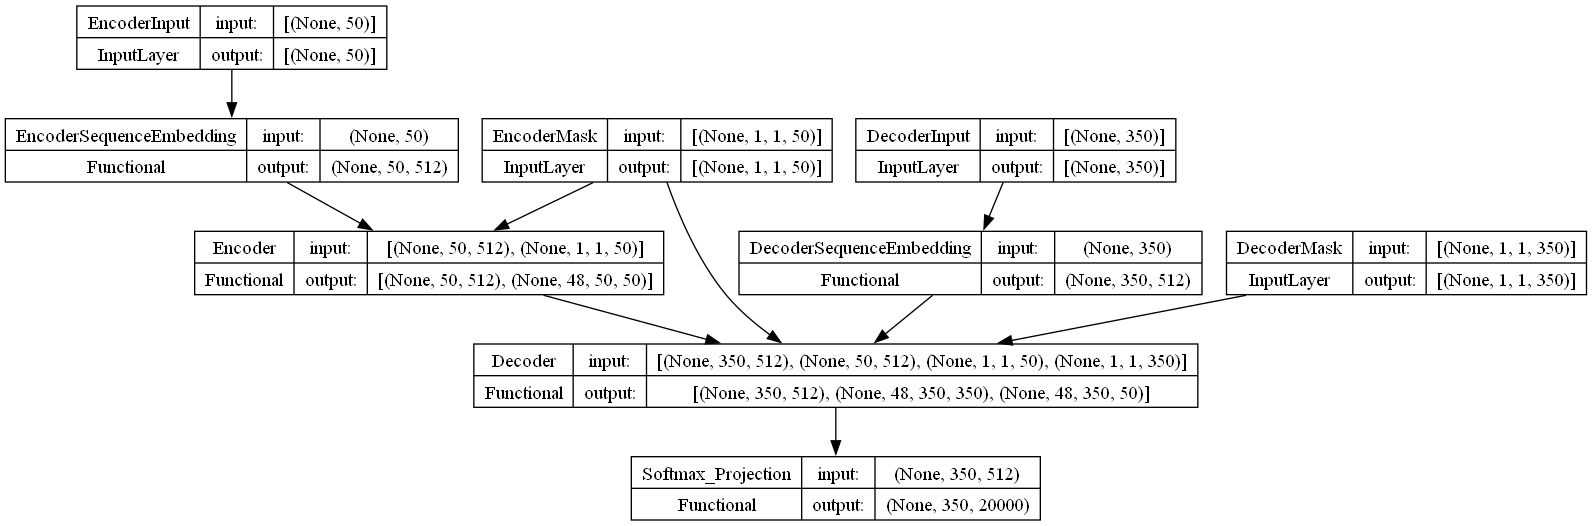

In [34]:
tf.keras.utils.plot_model(model,show_shapes=True)